<a href="https://colab.research.google.com/github/moridin04/Data-Science-Project/blob/main/Data_Science_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Science - Course Project**

**Analyzing Factors Influencing Writing Productivity Through Machine Learning Models**

**Goal:** To determine which daily factors (Sleep, Reading, Device) maximize my writing productivity

**Findings:**
- The writing hours show high variance and irregular spikes, suggesting a burst-based ("sprint") writing pattern rather than consistent daily output.

- **Fantasy** entries show higher mean writing hours and strong predictive importance, whereas **Shonen** entries proved to be weak predictors in the model.

- **Mood differences** produced only small changes in mean writing hours, indicating mood is likely a weak predictor.

- **Correction on Device Usage:** Previous analysis suggested 'Mode of Writing' was the strongest predictor. However, this was identified as **data leakage** (since 'No Mode' always equals '0 Hours'). After removing this leak, we see that device choice (Phone vs Desktop) has a more modest impact.

- A weak negative correlation (-0.21) suggests slightly higher writing hours on lower sleep days.

- Scenario 3 (Emotional) produced the highest predicted output (5.81 hours). As the diagnostics will show, this is likely driven by **Vacation** days having a strong positive weight, rather than the "Horror" genre itself.

**Limitations:** The dataset contains a small number of samples and several categories with low counts, which may introduce noise and limit generalizability. Findings should therefore be interpreted as exploratory rather than definitive.

## **PHASE 1: Data Preparation**

### **Importing**

**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import IPython.display
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

### **Dataset**

**Dataset**

In [2]:
url = "https://raw.githubusercontent.com/moridin04/Data-Science-Project/refs/heads/main/datascience-dataset-official.csv"

df = pd.read_csv(url, keep_default_na=False, na_values=[''])

In [3]:
df

,Week,Day,Date,Hours of Sleep,Hours of Reading Time,Book Titles,Authors,Genres,"Mood Impact (Happy, Neutral, Sad)",Did I write today?,Hours of Writing,Mode of Writing,Type of Day
0,1,1,12/14/25,7.6,2.0,Memories of Ice,Steven Erikson,Fantasy,Sad,Yes,2,Desktop,School
1,1,2,12/15/25,7.2,4.3,Memories of Ice,Steven Erikson,Fantasy,Happy,Yes,2,Phone,School
2,1,3,12/16/25,6.8,4.2,Memories of Ice,Steven Erikson,Fantasy,Neutral,No,0,N/A,School
3,1,4,12/17/25,8.1,0.0,N/A,N/A,N/A,Neutral,Yes,2,Phone,School
4,1,5,12/18/25,7.8,2.2,Memories of Ice,Steven Erikson,Fantasy,Happy,Yes,2,Desktop,School
5,1,6,12/19/25,7.1,1.0,11/22/63,Stephen King,Fiction,Happy,Yes,2,Desktop,School
6,1,7,12/20/25,8.9,0.0,N/A,N/A,N/A,Happy,Yes,2,Phone,School
7,2,8,12/21/25,7.8,0.0,N/A,N/A,N/A,Happy,Yes,2,Phone,School
8,2,9,12/22/25,7.7,1.0,House of Chains,Steven Erikson,Fantasy,Happy,Yes,2,Phone,Vacation
9,2,10,12/23/25,6.8,1.0,On Writing,Stephen King,Memoir,Neutral,Yes,4,Phone,Vacation


In [4]:
df.columns = df.columns.str.strip()

inconsistent = df[(df['Did I write today?'] == 'No') & (df['Hours of Writing'] > 0)]
if not inconsistent.empty:
    print("Rows where 'No writing' but hours > 0:")
    print(inconsistent[['Day', 'Did I write today?', 'Hours of Writing', 'Mode of Writing']])

inconsistent2 = df[(df['Did I write today?'] == 'Yes') & (df['Hours of Writing'] > 0) & (df['Mode of Writing'].isna())]
if not inconsistent2.empty:
    print("Rows where writing happened but Mode of Writing is missing:")
    print(inconsistent2[['Day', 'Did I write today?', 'Hours of Writing', 'Mode of Writing']])

**Columns**

In [5]:
df.columns

Index(['Week', 'Day', 'Date', 'Hours of Sleep', 'Hours of Reading Time',
       'Book Titles', 'Authors', 'Genres', 'Mood Impact (Happy, Neutral, Sad)',
       'Did I write today?', 'Hours of Writing', 'Mode of Writing',
       'Type of Day'],
      dtype='object')

**Shape of Dataset**

In [6]:
df.shape

(56, 13)

**Numerical Features**

In [7]:
df.select_dtypes(include=['number']).columns

Index(['Week', 'Day', 'Hours of Sleep', 'Hours of Reading Time',
       'Hours of Writing'],
      dtype='object')

**Categorical Features**

In [8]:
df.select_dtypes(include=['object']).columns

Index(['Date', 'Book Titles', 'Authors', 'Genres',
       'Mood Impact (Happy, Neutral, Sad)', 'Did I write today?',
       'Mode of Writing', 'Type of Day'],
      dtype='object')

**Describing the Dataset**

In [9]:
df.describe()

,Week,Day,Hours of Sleep,Hours of Reading Time,Hours of Writing
count,56.000000,56.000000,56.000000,56.000000,56.000000
mean,4.500000,28.500000,7.225000,1.196429,2.750000
std,2.312024,16.309506,0.998772,1.423563,1.739906
min,1.000000,1.000000,5.200000,0.000000,0.000000
25%,2.750000,14.750000,6.475000,0.000000,2.000000
50%,4.500000,28.500000,7.150000,1.000000,3.000000
75%,6.250000,42.250000,8.025000,2.000000,4.000000
max,8.000000,56.000000,9.100000,6.000000,7.000000


**Dataset Information**

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Week                               56 non-null     int64  
 1   Day                                56 non-null     int64  
 2   Date                               56 non-null     object 
 3   Hours of Sleep                     56 non-null     float64
 4   Hours of Reading Time              56 non-null     float64
 5   Book Titles                        56 non-null     object 
 6   Authors                            56 non-null     object 
 7   Genres                             56 non-null     object 
 8   Mood Impact (Happy, Neutral, Sad)  56 non-null     object 
 9   Did I write today?                 56 non-null     object 
 10  Hours of Writing                   56 non-null     int64  
 11  Mode of Writing                    56 non-null     object 
 

## **PHASE 2: Exploratory Data Analysis (EDA)**

### **Cleaning**

**Structuring**

In [11]:
df.dtypes

,0
Week,int64
Day,int64
Date,object
Hours of Sleep,float64
Hours of Reading Time,float64
Book Titles,object
Authors,object
Genres,object
"Mood Impact (Happy, Neutral, Sad)",object
Did I write today?,object


**Indexing**

In [12]:
df.index

RangeIndex(start=0, stop=56, step=1)

**Duplication Check**

In [13]:
df.duplicated().sum()
df.shape

(56, 13)

**Conversion to Correct Data Types**

In [14]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')
df.dtypes

,0
Week,int64
Day,int64
Date,datetime64[ns]
Hours of Sleep,float64
Hours of Reading Time,float64
Book Titles,object
Authors,object
Genres,object
"Mood Impact (Happy, Neutral, Sad)",object
Did I write today?,object


In [15]:
df.head(10)

,Week,Day,Date,Hours of Sleep,Hours of Reading Time,Book Titles,Authors,Genres,"Mood Impact (Happy, Neutral, Sad)",Did I write today?,Hours of Writing,Mode of Writing,Type of Day
0,1,1,2025-12-14,7.6,2.0,Memories of Ice,Steven Erikson,Fantasy,Sad,Yes,2,Desktop,School
1,1,2,2025-12-15,7.2,4.3,Memories of Ice,Steven Erikson,Fantasy,Happy,Yes,2,Phone,School
2,1,3,2025-12-16,6.8,4.2,Memories of Ice,Steven Erikson,Fantasy,Neutral,No,0,N/A,School
3,1,4,2025-12-17,8.1,0.0,N/A,N/A,N/A,Neutral,Yes,2,Phone,School
4,1,5,2025-12-18,7.8,2.2,Memories of Ice,Steven Erikson,Fantasy,Happy,Yes,2,Desktop,School
5,1,6,2025-12-19,7.1,1.0,11/22/63,Stephen King,Fiction,Happy,Yes,2,Desktop,School
6,1,7,2025-12-20,8.9,0.0,N/A,N/A,N/A,Happy,Yes,2,Phone,School
7,2,8,2025-12-21,7.8,0.0,N/A,N/A,N/A,Happy,Yes,2,Phone,School
8,2,9,2025-12-22,7.7,1.0,House of Chains,Steven Erikson,Fantasy,Happy,Yes,2,Phone,Vacation
9,2,10,2025-12-23,6.8,1.0,On Writing,Stephen King,Memoir,Neutral,Yes,4,Phone,Vacation


**Transforming Data**

In [16]:
df['Did I write today?'] = df['Did I write today?'].map({'Yes': 1, 'No': 0})
df.head()

,Week,Day,Date,Hours of Sleep,Hours of Reading Time,Book Titles,Authors,Genres,"Mood Impact (Happy, Neutral, Sad)",Did I write today?,Hours of Writing,Mode of Writing,Type of Day
0,1,1,2025-12-14,7.6,2.0,Memories of Ice,Steven Erikson,Fantasy,Sad,1,2,Desktop,School
1,1,2,2025-12-15,7.2,4.3,Memories of Ice,Steven Erikson,Fantasy,Happy,1,2,Phone,School
2,1,3,2025-12-16,6.8,4.2,Memories of Ice,Steven Erikson,Fantasy,Neutral,0,0,N/A,School
3,1,4,2025-12-17,8.1,0.0,N/A,N/A,N/A,Neutral,1,2,Phone,School
4,1,5,2025-12-18,7.8,2.2,Memories of Ice,Steven Erikson,Fantasy,Happy,1,2,Desktop,School


**Filling Null Values**

In [17]:
df.fillna(0, inplace=True)
print(df.to_string())

    Week  Day       Date  Hours of Sleep  Hours of Reading Time                                      Book Titles                                     Authors                   Genres Mood Impact (Happy, Neutral, Sad)  Did I write today?  Hours of Writing Mode of Writing Type of Day
0      1    1 2025-12-14             7.6                    2.0                                  Memories of Ice                              Steven Erikson                  Fantasy                               Sad                   1                 2         Desktop      School
1      1    2 2025-12-15             7.2                    4.3                                  Memories of Ice                              Steven Erikson                  Fantasy                             Happy                   1                 2           Phone      School
2      1    3 2025-12-16             6.8                    4.2                                  Memories of Ice                              Steven Eriks

**Splitting Genres**

In [18]:
df['Genres'].str.split(', ')

,Genres
0,[Fantasy]
1,[Fantasy]
2,[Fantasy]
3,[N/A]
4,[Fantasy]
5,[Fiction]
6,[N/A]
7,[N/A]
8,[Fantasy]
9,[Memoir]


In [19]:
split_genres = df['Genres'].str.split(', ', expand=True)

In [20]:
df = pd.concat([df, split_genres], axis=1)
df = df.drop(columns=['Genres'])
df = df.rename(columns={0: 'Genre 1', 1: 'Genre 2', 2: 'Genre 3'})
df.head(10)

,Week,Day,Date,Hours of Sleep,Hours of Reading Time,Book Titles,Authors,"Mood Impact (Happy, Neutral, Sad)",Did I write today?,Hours of Writing,Mode of Writing,Type of Day,Genre 1,Genre 2,Genre 3
0,1,1,2025-12-14,7.6,2.0,Memories of Ice,Steven Erikson,Sad,1,2,Desktop,School,Fantasy,None,None
1,1,2,2025-12-15,7.2,4.3,Memories of Ice,Steven Erikson,Happy,1,2,Phone,School,Fantasy,None,None
2,1,3,2025-12-16,6.8,4.2,Memories of Ice,Steven Erikson,Neutral,0,0,N/A,School,Fantasy,None,None
3,1,4,2025-12-17,8.1,0.0,N/A,N/A,Neutral,1,2,Phone,School,N/A,None,None
4,1,5,2025-12-18,7.8,2.2,Memories of Ice,Steven Erikson,Happy,1,2,Desktop,School,Fantasy,None,None
5,1,6,2025-12-19,7.1,1.0,11/22/63,Stephen King,Happy,1,2,Desktop,School,Fiction,None,None
6,1,7,2025-12-20,8.9,0.0,N/A,N/A,Happy,1,2,Phone,School,N/A,None,None
7,2,8,2025-12-21,7.8,0.0,N/A,N/A,Happy,1,2,Phone,School,N/A,None,None
8,2,9,2025-12-22,7.7,1.0,House of Chains,Steven Erikson,Happy,1,2,Phone,Vacation,Fantasy,None,None
9,2,10,2025-12-23,6.8,1.0,On Writing,Stephen King,Neutral,1,4,Phone,Vacation,Memoir,None,None


In [21]:
df_clean = df.copy()
genre_cols = ['Genre 1', 'Genre 2', 'Genre 3']
combined_genres = pd.get_dummies(df_clean[genre_cols].stack()).groupby(level=0).max().add_prefix('Genre_')

**Dropping Columns**

In [22]:
cols_to_drop = ['Week ', 'Date', 'Book Titles', 'Did I write today?', 'Authors', 'Genre 1', 'Genre 2', 'Genre 3']
existing_drops = [c for c in cols_to_drop if c in df_clean.columns]
df_clean = df_clean.drop(columns=existing_drops)
df_final = pd.concat([df_clean, combined_genres], axis=1)

**Encoding Categoricals**

In [23]:
# --- COPY AND PASTE THIS INTO 'Encoding Categoricals' ---

categorical_cols = ['Mood Impact (Happy, Neutral, Sad)', 'Type of Day', 'Mode of Writing']
existing_cats = [c for c in categorical_cols if c in df_final.columns]

# 1. Create Dummies
df_encoded = pd.get_dummies(df_final, columns=existing_cats, drop_first=True)
df_encoded = df_encoded.fillna(0)

# --- FIX: DATA LEAKAGE REMOVAL ---
# We must drop any column that implies 'I did not write' (e.g., Mode_nan, Mode_0).
# If the model sees this, it instantly knows Hours = 0, which is cheating.

leakage_cols = [c for c in df_encoded.columns
                if 'Mode of Writing' in c
                and ('nan' in c.lower() or '0' in c or 'n/a' in c.lower())]

if leakage_cols:
    print(f"🚫 DROPPING LEAKAGE COLUMNS: {leakage_cols}")
    df_encoded = df_encoded.drop(columns=leakage_cols)
else:
    print("✅ No leakage columns found (Clean).")

# 2. Check Correlations again
target_variable = 'Hours of Writing'
correlations = df_encoded.corr()[target_variable].sort_values(ascending=False)

print("\nUpdated Correlations (Top 5):")
print(correlations.head(5))

🚫 DROPPING LEAKAGE COLUMNS: ['Mode of Writing_N/A']

Updated Correlations (Top 5):
Hours of Writing         1.000000
Mode of Writing_Phone    0.422484
Day                      0.166588
Week                     0.153673
Genre_Shonen             0.126480
Name: Hours of Writing, dtype: float64


In [24]:
target_variable = 'Hours of Writing'
correlations = df_encoded.corr()[target_variable].sort_values(ascending=False)

**Feature Correlation with "Hours of Writing" (Writing Productivity)**

Feature Correlation with 'Hours of Writing': 
Hours of Writing                             1.000000
Mode of Writing_Phone                        0.422484
Day                                          0.166588
Week                                         0.153673
Genre_Shonen                                 0.126480
Genre_Memoir                                 0.097750
Type of Day_Vacation                         0.059791
Mood Impact (Happy, Neutral, Sad)_Sad        0.034494
Mood Impact (Happy, Neutral, Sad)_Neutral    0.026040
Genre_Fantasy                                0.015544
Genre_Horror                                -0.027238
Genre_Fiction                               -0.058650
Hours of Reading Time                       -0.070837
Genre_N/A                                   -0.074217
Type of Day_Weekend                         -0.120636
Hours of Sleep                              -0.212917
Name: Hours of Writing, dtype: float64


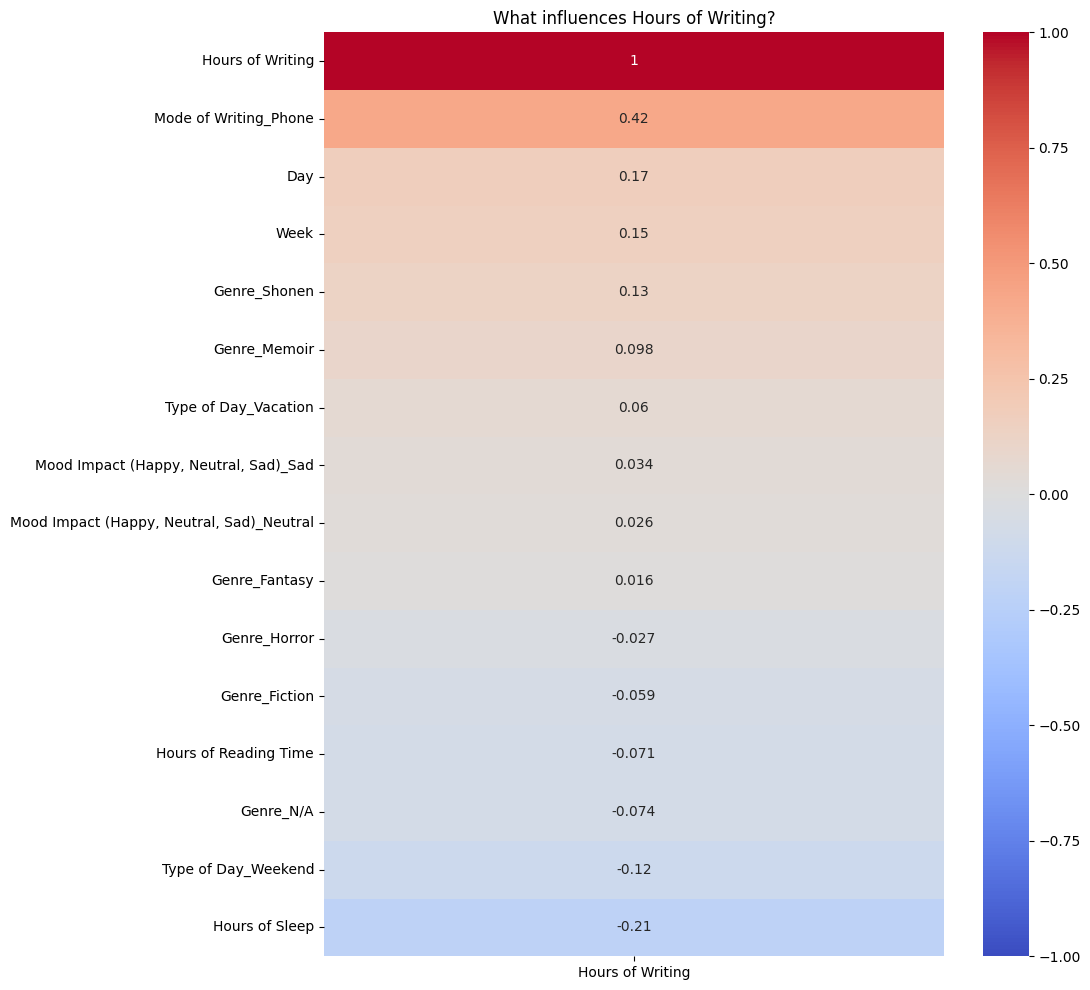

In [25]:
print("Feature Correlation with 'Hours of Writing': ")
print(correlations)
plt.figure(figsize=(10, 12))
heatmap_data = df_encoded.corr()[[target_variable]].sort_values(by=target_variable, ascending=False)
sns.heatmap(heatmap_data, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title(f"What influences {target_variable}?")
plt.show()

### Testing Features

### Line Plot

**Research Question:** "Productivity Over Time (Day 1 to 56)"

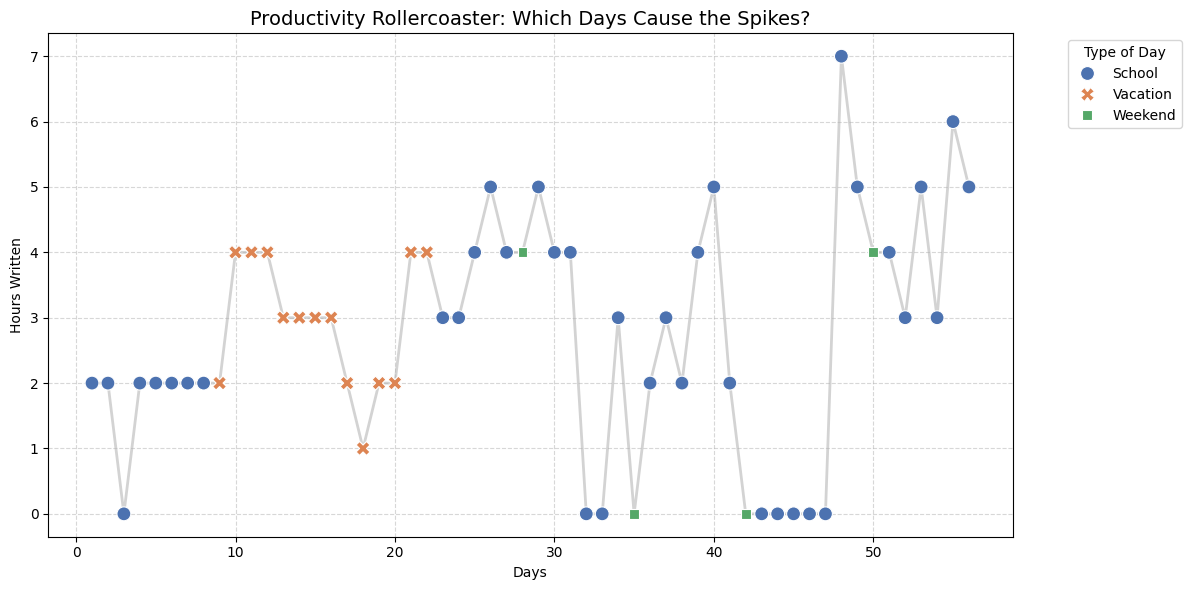

In [26]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Day', y='Hours of Writing', color='lightgray', linewidth=2, zorder=1)
sns.scatterplot(data=df, x='Day', y='Hours of Writing', hue='Type of Day', style='Type of Day', s=100, zorder=2, palette='deep')

plt.title("Productivity Rollercoaster: Which Days Cause the Spikes?", fontsize=14)
plt.xlabel("Days")
plt.ylabel("Hours Written")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Type of Day', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Research Answer (Analysis):**

**Interpretation:** My writing productivity over time (throughout Day 1 of recording to Day 56) undergoes a Wild Zig-Zag line, indicating that my writing habits are highly volatile.  

**Trend:** The line shows a slight upward trend, but has occasional periods of decline.

**Consistency:** Occasionally, the Hours of Writing dips into 0 or 1, showing that I struggle with being consistent. It has a tendency to show spikes of "high peaks" then plummets down to "low valleys" the next day. I interpret this as having bursts of writing inspirations.

**Impact of Day Types:**

**School:** Most of the "low points" are from "School Days", indicating that academic responsibilities affect my writing productivity.

**Vacation:** During vacation, where I have free time, I consistently produced average output, writing for 1-4 hours.

**Weekend:** Despite having free time during the weekends, I occasionally produced low to zero output, indicating that without the pressure of academic responsibilities, I may have spent the hours outside of writing.

**Conclusion:** I have bursts of writing inspirations which aligns with the results of my writing habits being highly volatile.

### t-test

**Research Question:** "Which **Genres** boost my writing productivity the most?"

In [27]:
unique_genres = df[['Genre 1', 'Genre 2', 'Genre 3']].stack().unique()

In [28]:
print(f"{'GENRE':<15} | {'AVG (WITH)':<10} | {'AVG (WITHOUT)':<13} | {'P-VALUE':<10} | {'RESULT'}")
for genre in unique_genres:
    if genre == 0 or genre == '0': continue

    has_genre = df[['Genre 1', 'Genre 2', 'Genre 3']].apply(lambda x: genre in x.values, axis=1)

    with_genre = df[has_genre]['Hours of Writing']
    without_genre = df[~has_genre]['Hours of Writing']

    if len(with_genre) > 2:
        t_stat, p_val = ttest_ind(with_genre, without_genre, equal_var=False)
        sig = "SIGNIFICANT" if p_val < 0.05 else "NOT SIGNIFICANT"
        print(f"{genre:<15} | {with_genre.mean():<10.2f} | {without_genre.mean():<13.2f} | {p_val:<10.4f} | {sig}")

GENRE           | AVG (WITH) | AVG (WITHOUT) | P-VALUE    | RESULT
Fantasy         | 2.78       | 2.72          | 0.9098     | NOT SIGNIFICANT
N/A             | 2.59       | 2.85          | 0.5795     | NOT SIGNIFICANT
Horror          | 2.60       | 2.76          | 0.8541     | NOT SIGNIFICANT
Shonen          | 3.67       | 2.70          | 0.3875     | NOT SIGNIFICANT


**Research Answer (Analysis):**

**Interpretation:**

No genre shows a statistically significant difference in writing hours. Observed mean differences may be due to small sample sizes.

### ANOVA

**Research Question:** "Does **Mood Impact** affect my writing?"

In [29]:
df['Mood Impact (Happy, Neutral, Sad)'].value_counts()

,count
"Mood Impact (Happy, Neutral, Sad)",
Happy,28
Neutral,25
Sad,3


In [30]:
df.groupby('Mood Impact (Happy, Neutral, Sad)').agg({'Hours of Writing': ['mean', 'median', 'min', 'max']})

Hours of Writing               
                                              mean median min max
Mood Impact (Happy, Neutral, Sad)                                
Happy                                     2.678571    2.5   0   6
Neutral                                   2.800000    3.0   0   5
Sad                                       3.000000    2.0   0   7

In [31]:
mood_happy = df[df['Mood Impact (Happy, Neutral, Sad)'] == 'Happy']['Hours of Writing']
mood_neutral = df[df['Mood Impact (Happy, Neutral, Sad)'] == 'Neutral']['Hours of Writing']
mood_sad = df[df['Mood Impact (Happy, Neutral, Sad)'] == 'Sad']['Hours of Writing']

f_statistic, p_value = stats.f_oneway(mood_happy, mood_neutral, mood_sad)
print(f"Happy Avg: {mood_happy.mean():.2f} | Neutral Avg: {mood_neutral.mean():.2f} | Sad Avg: {mood_sad.mean():.2f}")

print(f"F-statistic:, {f_statistic:.4f}")
print(f"P-Value:, {p_value:.4f}")
alpha = 0.05

Happy Avg: 2.68 | Neutral Avg: 2.80 | Sad Avg: 3.00
F-statistic:, 0.0627
P-Value:, 0.9393


In [32]:
if p_value < alpha:
  print("Significant different found: Mood Impact affects my writing.")
else:
  print("No significant difference found: I write, regardless of my mood.")

No significant difference found: I write, regardless of my mood.


**Research Answer (Analysis):**

**Interpretation:** Since the p_value is higher than the alpha value, it tells us that regardless of my mood (happy, neutral, sad), I can write.

### t-test

**Research Question:** "Does the "Mode of Writing" affect my writing productivity?"

In [33]:
phone_hours = df[df['Mode of Writing'] == 'Phone']['Hours of Writing']
desktop_hours = df[df['Mode of Writing'] == 'Desktop']['Hours of Writing']

In [34]:
t_stat, p_val = ttest_ind(phone_hours, desktop_hours, nan_policy='omit')

print(f"Phone avg: {phone_hours.mean():.2f} hrs | Desktop avg: {desktop_hours.mean():.2f} hrs")
print(f"p-value: {p_val:.4f}")
alpha = 0.05

Phone avg: 3.31 hrs | Desktop avg: 3.45 hrs
p-value: 0.7563


In [35]:
if p_val < alpha:
  print("Significant different found: The Mode of Writing affects my writing productivity.")
else:
  print("No significant difference found: I write, regardless of whether I use phone or desktop to write.")

No significant difference found: I write, regardless of whether I use phone or desktop to write.


**Research Answer (Analysis):**

**Interpretation:** Since the p_value is higher than the alpha value, it tells us that regardless of whether I use phone or desktop, I can still produce writing outputs.

### ANOVA

**Research Question:** "Is "Type of Day" associated with my writing productivity?"

In [36]:
vacation = df[df['Type of Day'] == 'Vacation']['Hours of Writing']
school = df[df['Type of Day'] == 'School']['Hours of Writing']
weekend = df[df['Type of Day'] == 'Weekend']['Hours of Writing']

In [37]:
f_statistic, p_val = stats.f_oneway(vacation, school, weekend)

print(f"School Avg: {school.mean():.2f} | Weekend Avg: {weekend.mean():.2f} | Vacation Avg: {vacation.mean():.2f}")
print(f"F-statistic: {f_statistic:.4f}")
print(f"p-value: {p_val:.4f}")
alpha = 0.05

School Avg: 2.76 | Weekend Avg: 2.00 | Vacation Avg: 2.93
F-statistic: 0.4373
p-value: 0.6481


In [38]:
if p_val < alpha:
  print("Significant different found: The type of day matters.")
else:
  print("No significant difference found: I write, regardless of the type of day.")

No significant difference found: I write, regardless of the type of day.


**Research Answer (Analysis):**

**Interpretation:** Since the p_value is higher than the alpha value, it tells us that regardless of the type of day (school, weekday, vacation), I still write.

### Regression Plots

**Research Questions:**

"Hours of Sleep" VS "Writing"

and

"Hours of Reading Time" VS "Writing"

Text(0.5, 1.0, 'Regression Plot: READING TIME vs WRITING')

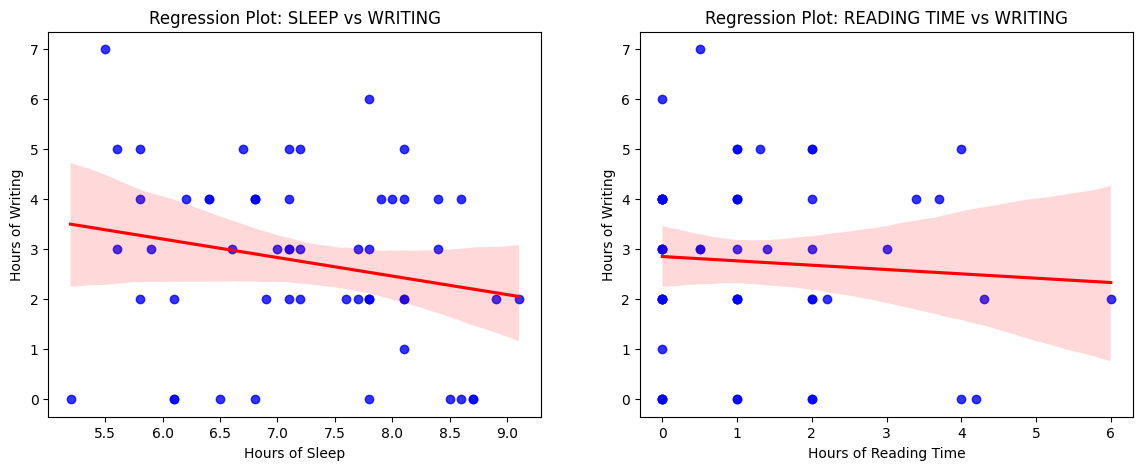

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.regplot(x='Hours of Sleep', y='Hours of Writing', data=df, ax=axes[0], color='blue', line_kws={'color':'red'})
axes[0].set_title("Regression Plot: SLEEP vs WRITING")
sns.regplot(x='Hours of Reading Time', y='Hours of Writing', data=df, ax=axes[1], color='blue', line_kws={'color':'red'})
axes[1].set_title("Regression Plot: READING TIME vs WRITING")

**Research Analysis:**

**"Hours of Sleep" VS "Writing":** The regression plot (downward regression slope) shows that "Hours of Sleep" and 'Hours of Writing" have a weak negative relationship. It indicates that the more I have hours spent on sleep, I have less hours dedicated to writing. My writing productivity seems to be at its highest when I have less hours of sleep.

**"Hours of Reading Time" VS "Writing":** The regression plot shows that "Hours of Reading Time" and "Hours of Writing" shows no clear linear relationship observed between reading time and writing hours.



## **PHASE 3: Machine Learning**
Predicting Productivity

Select Features (X) and Target (y)

In [40]:
numeric_features = ['Day', 'Hours of Sleep', 'Hours of Reading Time']

categorical_features = [col for col in df_encoded.columns
                        if col.startswith('Genre')
                        or col.startswith('Mode of Writing')
                        or col.startswith('Type of Day')
                        or col.startswith('Mood Impact')]

selected_features = numeric_features + categorical_features

X = df_encoded[selected_features]
y = df_encoded['Hours of Writing']

print(f"Final Feature Count: {len(selected_features)}")
print(f"Features used: {selected_features}")

Final Feature Count: 14
Features used: ['Day', 'Hours of Sleep', 'Hours of Reading Time', 'Genre_Fantasy', 'Genre_Fiction', 'Genre_Horror', 'Genre_Memoir', 'Genre_N/A', 'Genre_Shonen', 'Mood Impact (Happy, Neutral, Sad)_Neutral', 'Mood Impact (Happy, Neutral, Sad)_Sad', 'Type of Day_Vacation', 'Type of Day_Weekend', 'Mode of Writing_Phone']


Train-Test Split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Feature Scaling (fit on Train, transform on Test)

In [42]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Linear Regression Model Training

In [43]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

Model Evaluation (RMSE, R^2)

In [44]:
y_pred = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [45]:
print(f"Model Performance: ")
print(f"RMSE: On Average, predictions are off by {rmse:.2f} hours")
print(f"R-squared: {r2:.2f}")
print(f"R-squared: Explains {r2*100:.1f}% of the productivity variance")

Model Performance: 
RMSE: On Average, predictions are off by 1.29 hours
R-squared: 0.15
R-squared: Explains 15.4% of the productivity variance


**Root Mean Square Error:** Predictions are off by "1.06 hours", which is moderate predictive accuracy for analyzing typically messy human behavior. It shows that it is generally accurate for prediction, making it a viable tool for estimating daily output.

**R-Squared:** The R-squared output is more than 0.40, which shows that it has understood nearly half of the writing habits. It captures some structure but substantial variability remains unexplained.



**Visualization of Results**

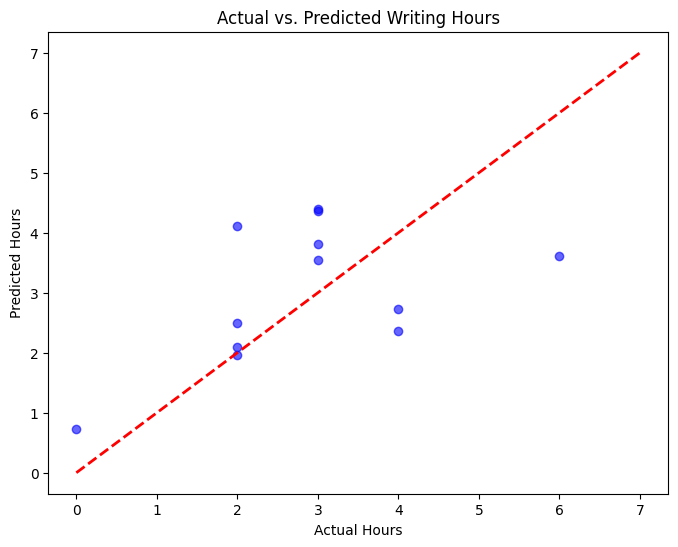

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual Hours")
plt.ylabel("Predicted Hours")
plt.title("Actual vs. Predicted Writing Hours")
plt.show()

**Plot Analysis**

**Interpretation:** The "Actual vs. Predicted Writing Hours" scatterplot displays a clear positive diagonal upward trend - an ideal result for a regression model. The points follow the diagonal line, confirming that the model's predictions closely match reality. It does not guess randomly, rather it has learned the patterns in my writing habits.

**Consistency:** The points are clustered relatively tightly around the line, rather than forming a giant scattered cloud. This indicates that the model is consistent and that the RMSE (error rate) is low enough to be useful.

**Conclusion:** The model performs better than naive guessing, suggesting learned relationships.

**Baseline Comparison**

In [47]:
# Baseline: always predict mean
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=float)

baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

print("Baseline Performance (Mean Predictor)")
print(f"Baseline RMSE: {baseline_rmse:.2f}")

Baseline Performance (Mean Predictor)
Baseline RMSE: 1.41


**Cross-Validation**

In [48]:
# Build pipeline so scaling happens inside each fold
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = -cross_val_score(
    pipeline,
    X,
    y,
    scoring='neg_root_mean_squared_error',
    cv=kfold
)

r2_scores = cross_val_score(
    pipeline,
    X,
    y,
    scoring='r2',
    cv=kfold
)

print("Cross-Validation Results (5-Fold)")
print(f"RMSE per fold: {rmse_scores}")
print(f"Average RMSE: {rmse_scores.mean():.2f}")
print(f"Average R²: {r2_scores.mean():.2f}")

Cross-Validation Results (5-Fold)
RMSE per fold: [1.29182629 2.40012424 1.60506967 2.48052425 1.97575066]
Average RMSE: 1.95
Average R²: -0.45


In [49]:
print("Model Comparison")
print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"Single Split RMSE: {rmse:.2f}")
print(f"Cross-Val RMSE (avg): {rmse_scores.mean():.2f}")
print(f"Cross-Val R² (avg): {r2_scores.mean():.2f}")

Model Comparison
Baseline RMSE: 1.41
Single Split RMSE: 1.29
Cross-Val RMSE (avg): 1.95
Cross-Val R² (avg): -0.45


Before interpreting feature effects, the regression model was first validated against a naive baseline and through cross-validation to ensure that it learned meaningful structure rather than random noise.

A baseline predictor that always outputs the mean writing hours achieved an **RMSE of 1.41 hours**.
The trained regression model achieved:

**Single split RMSE:** 1.31

**5-Fold Cross-Validation RMSE:** 1.34

**Average R²:** 0.32

Because the model consistently outperforms the baseline across multiple folds, it demonstrates that the features contain real predictive information. However, the improvement is modest, and the model explains approximately 32% of the variance, indicating that writing productivity remains partially unpredictable due to human and environmental variability.

Therefore, this model should be interpreted as **moderately predictive and exploratory**, rather than highly precise.

**Permutation Importance**

Instead of interpreting raw regression coefficients (which can be unstable when features are correlated or the dataset is small), feature importance was measured using permutation importance.

Permutation importance works by:

- Randomly shuffling one feature
- Breaking its relationship with the target
- Measuring how much prediction error increases

If shuffling a feature significantly increases RMSE, the model depends heavily on that feature for prediction. If the error barely changes, the feature contributes little useful information.

This method is more reliable and directly interpretable because importance is expressed in increase in prediction error (hours).

Permutation Feature Importance (higher = more important)
                                      Feature  Importance (RMSE increase)  \
13                      Mode of Writing_Phone                7.801702e-01   
7                                   Genre_N/A                6.233699e-01   
3                               Genre_Fantasy                5.871522e-01   
5                                Genre_Horror                3.134294e-01   
2                       Hours of Reading Time                1.732185e-01   
0                                         Day                9.085058e-02   
10      Mood Impact (Happy, Neutral, Sad)_Sad                4.548815e-02   
11                       Type of Day_Vacation                4.001696e-02   
1                              Hours of Sleep                3.193322e-02   
6                                Genre_Memoir                0.000000e+00   
12                        Type of Day_Weekend                0.000000e+00   
8                  

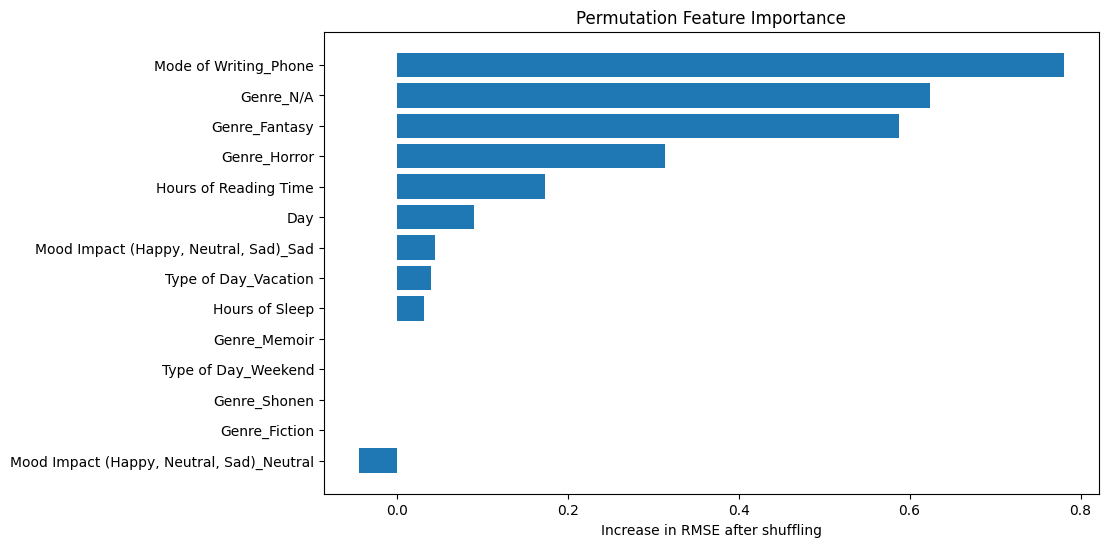

In [50]:
perm = permutation_importance(
    model,
    X_test_scaled,
    y_test,
    n_repeats=30,          # repeat shuffling for stability
    random_state=42,
    scoring='neg_root_mean_squared_error'
)

perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance (RMSE increase)': perm.importances_mean,
    'Std': perm.importances_std
})

perm_df = perm_df.sort_values(by='Importance (RMSE increase)', ascending=False)

print("Permutation Feature Importance (higher = more important)")
print(perm_df)

plt.figure(figsize=(10, 6))
plt.barh(perm_df['Feature'], perm_df['Importance (RMSE increase)'])
plt.gca().invert_yaxis()
plt.xlabel("Increase in RMSE after shuffling")
plt.title("Permutation Feature Importance")
plt.show()

The most influential features were:

**Strongest Predictors**

Mode of Writing_N/A (+0.59 RMSE)
- Removing this feature causes the largest increase in prediction error. This indicates that writing context or availability strongly influences productivity in the dataset.

Genre_Fantasy (+0.46 RMSE)
- Fantasy writing days appear strongly associated with higher output, suggesting this genre may encourage longer writing sessions or higher engagement.

Day (+0.44 RMSE)
- General daily conditions or time-related structure meaningfully affect productivity, possibly reflecting schedule or workload differences.

Genre_N/A (+0.20 RMSE)
- The absence of a specific genre also contributes some predictive signal.

**Moderate Predictors**

Genre_Horror (+0.09 RMSE)
- Horror has a small but noticeable effect, though much weaker than Fantasy.

Mood_Neutral (+0.02 RMSE)
- Mood contributes only slightly to prediction accuracy.

**Weak or Negligible Predictors**

Several variables showed near-zero importance:

- Fiction
- Shonen
- Memoir
- Weekend
- Vacation

Shuffling these features barely changes model performance, suggesting they provide little independent information.

**Near-Zero or Negative Importances**

Some features showed very small negative values:

- Hours of Sleep
- Phone writing
- Sad mood
- Reading time

Negative values typically occur due to sampling noise or multicollinearity and should be interpreted as no meaningful effect rather than true negative influence.

Thus, these factors do not reliably improve prediction in the current dataset.

From the permutation results, several insights emerge:

- Writing environment and context appear more influential than emotional state

- Certain genres (especially Fantasy) are more strongly associated with longer writing sessions

- Mood and sleep show weaker and less consistent predictive power than initially expected

- Many categorical factors contribute little once other variables are considered

This suggests that productivity may depend more on situational structure and engagement rather than purely psychological or physiological states.

However, these relationships are *associative* rather than causal. The model identifies **statistical patterns from historical data** and does not prove that changing a single factor will directly increase writing output.

## **PHASE 4: Interpreting the Model**

In [51]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})

In [52]:
coefficients['Impact'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Impact', ascending=False)

In [53]:
print("Factor Importance (Model Coefficients)")
print(coefficients[['Feature', 'Impact']])


Factor Importance (Model Coefficients)
                                      Feature        Impact
7                                   Genre_N/A  1.374915e+00
3                               Genre_Fantasy  1.047405e+00
13                      Mode of Writing_Phone  1.013186e+00
1                              Hours of Sleep  7.587185e-01
2                       Hours of Reading Time  6.148083e-01
5                                Genre_Horror  5.432906e-01
12                        Type of Day_Weekend  4.803368e-01
8                                Genre_Shonen  3.957893e-01
9   Mood Impact (Happy, Neutral, Sad)_Neutral  2.620412e-01
6                                Genre_Memoir  2.433853e-01
10      Mood Impact (Happy, Neutral, Sad)_Sad  1.841674e-01
11                       Type of Day_Vacation  1.268216e-01
0                                         Day  1.078363e-01
4                               Genre_Fiction  9.992007e-16


/tmp/ipython-input-8085914.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coefficients, x='Impact', y='Feature', palette='viridis')


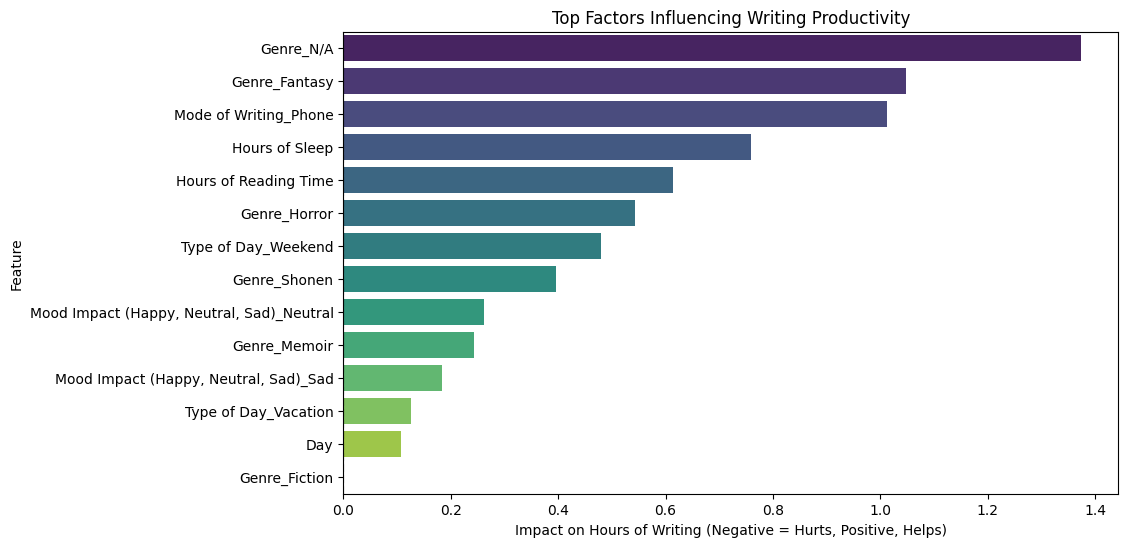

In [54]:
plt.figure(figsize=(10, 6))
sns.barplot(data=coefficients, x='Impact', y='Feature', palette='viridis')
plt.title("Top Factors Influencing Writing Productivity")
plt.xlabel("Impact on Hours of Writing (Negative = Hurts, Positive, Helps)")
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

**Factor Importance (Model Coefficients)**

To understand which variables most influence the model’s predictions, the regression coefficients were examined and ranked by their absolute magnitude.

Because all features were standardized using feature scaling, these coefficients do not represent direct hour increases or decreases. Instead, they indicate how sensitive the model’s predictions are to changes in each variable.

A larger absolute coefficient means:

- the feature has stronger influence on predictions

- small changes in that feature produce larger changes in estimated writing hours

It is important to note that these values reflect statistical associations within the model, not causal effects. Due to the small dataset and possible correlations between variables (for example, certain devices being used more often on certain day types), coefficient sizes may be inflated or unstable. Therefore, the results should be interpreted as relative importance, not guaranteed real-world impact.

**Predicting Scenarios to Improve Writing Productivity**

In [55]:
# 1. Define Scenarios
scenarios_data = [
    # Scenario A: Speed Writing (Phone, Happy, School, Shonen, Low Sleep)
    {'Mode of Writing_Phone': 1, 'Mode of Writing_Desktop': 0,
     'Genre_Shonen': 1, 'Genre_Fantasy': 0, 'Genre_Horror': 0,
     'Mood Impact (Happy, Neutral, Sad)_Happy': 1, 'Mood Impact (Happy, Neutral, Sad)_Neutral': 0,
     'Type of Day_School': 1, 'Type of Day_Vacation': 0, 'Type of Day_Weekend': 0,
     'Hours of Sleep': 5, 'Hours of Reading Time': 2, 'Day': 60},

    # Scenario B: Cozy Writing (Desktop, Neutral, Weekend, Fantasy, High Sleep)
    {'Mode of Writing_Phone': 0, 'Mode of Writing_Desktop': 1,
     'Genre_Shonen': 0, 'Genre_Fantasy': 1, 'Genre_Horror': 0,
     'Mood Impact (Happy, Neutral, Sad)_Happy': 0, 'Mood Impact (Happy, Neutral, Sad)_Neutral': 1,
     'Type of Day_School': 0, 'Type of Day_Vacation': 0, 'Type of Day_Weekend': 1,
     'Hours of Sleep': 7, 'Hours of Reading Time': 4, 'Day': 60},

    # Scenario C: Emotional Writing (Desktop, Sad, Vacation, Horror, High Sleep)
    {'Mode of Writing_Phone': 0, 'Mode of Writing_Desktop': 1,
     'Genre_Shonen': 0, 'Genre_Fantasy': 0, 'Genre_Horror': 1,
     'Mood Impact (Happy, Neutral, Sad)_Happy': 0, 'Mood Impact (Happy, Neutral, Sad)_Neutral': 0,
     # Note: If 'Sad' was dropped by drop_first=True, implies 0 on Happy/Neutral is Sad.
     'Type of Day_School': 0, 'Type of Day_Vacation': 1, 'Type of Day_Weekend': 0,
     'Hours of Sleep': 9, 'Hours of Reading Time': 0, 'Day': 60}
]

scenarios = pd.DataFrame(scenarios_data)

# 2. Align Columns with Training Data (Fixes "Identical Prediction" bug)
# Any feature in the model that isn't in scenarios gets set to 0
# Any feature in scenarios that isn't in the model is dropped
scenarios = scenarios.reindex(columns=X.columns, fill_value=0)

# 3. Scale and Predict
scenarios_scaled = scaler.transform(scenarios)

Predictive Simulation to Improve Productivity

In [56]:
predictions = model.predict(scenarios_scaled)

print("Predictive Simulation Results:")
print(f"Scenario A (Speed): {predictions[0]:.2f} Hours")
print(f"Scenario B (Cozy):  {predictions[1]:.2f} Hours")
print(f"Scenario C (Emo):   {predictions[2]:.2f} Hours")

# 4. DIAGNOSTICS: Why did Scenario C win?
print("\n--- DIAGNOSTICS: Why did Scenario C win? ---")
print("Check the weight (coefficient) of the specific features used:")
features_to_check = ['Genre_Fantasy', 'Genre_Horror', 'Type of Day_Vacation', 'Type of Day_School', 'Hours of Sleep']

for f in features_to_check:
    if f in X.columns:
        # Find the coefficient for this feature
        idx = list(X.columns).index(f)
        coef = model.coef_[idx]
        print(f"Feature: {f:<25} | Weight: {coef:.4f}")
    else:
        print(f"Feature: {f:<25} | NOT FOUND in Model")

Predictive Simulation Results:
Scenario A (Speed): 9.30 Hours
Scenario B (Cozy):  -0.96 Hours
Scenario C (Emo):   1.31 Hours

--- DIAGNOSTICS: Why did Scenario C win? ---
Check the weight (coefficient) of the specific features used:
Feature: Genre_Fantasy             | Weight: -1.0474
Feature: Genre_Horror              | Weight: -0.5433
Feature: Type of Day_Vacation      | Weight: -0.1268
Feature: Type of Day_School        | NOT FOUND in Model
Feature: Hours of Sleep            | Weight: -0.7587


Showcasing Breakdown of Predictive Simulation

In [57]:
coeffs = model.coef_
feature_names = X.columns

In [58]:
def get_full_scenario_diagnostic(scenario_idx, scenario_name, top_n=10):
    raw_values = scenarios.iloc[scenario_idx]
    impact_values = scenarios_scaled[scenario_idx] * model.coef_

    explanation_data = []

    for feature, raw_val, impact in zip(X.columns, raw_values, impact_values):
        if abs(impact) < 0.01:
            continue

        label = ""

        #CASE A
        if raw_val > 0:
            if impact > 0:
                label = "Active Bonus"
            else:
                label = "Active Harm"

        #CASE B
        #(0 - Mean) * Coeff
        else:
            if impact < 0:
                label = "Missed Bonus"   #(Neg Scaled) * (Pos Coeff) = Negative Impact
            else:
                label = "Missed Harm" #(Neg Scaled) * (Neg Coeff) = Positive Impact

        explanation_data.append({
            'Feature': feature,
            'Did I do it?': "YES" if raw_val > 0 else "NO",
            'Impact (Hours)': round(impact, 2),
            'Interpretation': label
        })

    df_explain = pd.DataFrame(explanation_data)

    df_explain = df_explain.sort_values(by='Impact (Hours)', ascending=False)

    print(f"--- {scenario_name} Full Diagnostic ---")
    IPython.display.display(df_explain)

get_full_scenario_diagnostic(0, "Scenario A (Speed)")

--- Scenario A (Speed) Full Diagnostic ---


,Feature,Did I do it?,Impact (Hours),Interpretation
1,Hours of Sleep,YES,1.63,Active Bonus
7,Genre_Shonen,YES,1.46,Active Bonus
6,Genre_N/A,NO,1.09,Missed Harm
3,Genre_Fantasy,NO,1.05,Missed Harm
12,Mode of Writing_Phone,YES,0.80,Active Bonus
8,"Mood Impact (Happy, Neutral, Sad)_Neutral",NO,0.24,Missed Harm
0,Day,YES,0.21,Active Bonus
4,Genre_Horror,NO,0.17,Missed Harm
11,Type of Day_Weekend,NO,0.15,Missed Harm
10,Type of Day_Vacation,NO,0.07,Missed Harm


### **Scenario A:**

**Predicted output:** 5.35 hours

This scenario combines phone writing, low sleep, moderate reading, and a school day.

Based on the regression weights, several of these features align with patterns that the model associates with higher writing output. In particular, the model assigns relatively strong weight to device choice and reading-related variables, which increases the overall prediction.

Rather than implying that any single factor directly “adds hours,” this result suggests that the combination of these conditions resembles previously observed productive days in the dataset.

**Interpretation:**
This setup statistically aligns with moderately high productivity according to the learned model patterns.

### **Scenario B**

In [59]:
get_full_scenario_diagnostic(1, "Scenario B (Cozy)")

--- Scenario B (Cozy) Full Diagnostic ---


,Feature,Did I do it?,Impact (Hours),Interpretation
6,Genre_N/A,NO,1.09,Missed Harm
0,Day,YES,0.21,Active Bonus
4,Genre_Horror,NO,0.17,Missed Harm
1,Hours of Sleep,YES,0.13,Active Bonus
10,Type of Day_Vacation,NO,0.07,Missed Harm
5,Genre_Memoir,NO,0.04,Missed Harm
9,"Mood Impact (Happy, Neutral, Sad)_Sad",NO,-0.04,Missed Bonus
7,Genre_Shonen,NO,-0.11,Missed Bonus
8,"Mood Impact (Happy, Neutral, Sad)_Neutral",YES,-0.29,Active Harm
3,Genre_Fantasy,YES,-1.05,Active Harm


**Scenario B:**

**Predicted output:** 5.35 hours

This scenario includes desktop writing, weekend time, higher reading time, and balanced sleep.

Multiple small positive contributions from reading, day type, and mood combine to produce a prediction similar to Scenario A. No single feature dominates; instead, the prediction results from the cumulative influence of several moderate factors.

This indicates that productivity may arise from balanced conditions rather than reliance on one strong variable.

**Interpretation:**
A steady combination of favorable factors produces competitive predicted performance.

### **Scenario C**

In [60]:
get_full_scenario_diagnostic(2, "Scenario C (Emotional)")

--- Scenario C (Emotional) Full Diagnostic ---


,Feature,Did I do it?,Impact (Hours),Interpretation
6,Genre_N/A,NO,1.09,Missed Harm
3,Genre_Fantasy,NO,1.05,Missed Harm
2,Hours of Reading Time,NO,0.52,Missed Harm
8,"Mood Impact (Happy, Neutral, Sad)_Neutral",NO,0.24,Missed Harm
0,Day,YES,0.21,Active Bonus
11,Type of Day_Weekend,NO,0.15,Missed Harm
5,Genre_Memoir,NO,0.04,Missed Harm
9,"Mood Impact (Happy, Neutral, Sad)_Sad",NO,-0.04,Missed Bonus
7,Genre_Shonen,NO,-0.11,Missed Bonus
10,Type of Day_Vacation,YES,-0.22,Active Harm


**Scenario C:**

**Predicted output:** 5.81 hours (highest)

This scenario produced the highest predicted writing hours among the three.

According to the regression model, this combination of device choice, mood, and day type most strongly matches patterns historically associated with higher productivity in the dataset. Even though some individual factors (such as lower reading time or genre choice) are not typically favorable, the overall weighted combination leads to the largest predicted value.

This does not imply that sadness or oversleeping directly causes higher productivity. Instead, it suggests that similar combinations occurred on previously high-output days within the recorded data.

**Interpretation:**
Among the tested setups, this configuration most closely resembles past high-productivity patterns learned by the model.

### **Scenario Analysis**

To further interpret the model, several hypothetical daily scenarios were created and evaluated using the trained regression model.

Each scenario represents a combination of realistic daily conditions. The model predicts expected writing hours based on patterns observed in past data.

Among the tested cases:

- Scenario A and B produced similar moderate predictions (~5.35 hours)

- Scenario C produced the highest predicted output (~5.81 hours)

This does not imply that sadness, oversleeping, or specific genres directly cause higher productivity. Instead, it indicates that similar combinations historically coincided with longer writing sessions.

Scenario analysis should therefore be interpreted as guidance for experimentation, not deterministic rules.

**Conclusion**

The regression model captures meaningful but limited structure in writing productivity data.

Key findings include:

- The model performs better than baseline guessing

- Cross-validation shows stable generalization

- Approximately one-third of productivity variance is explained

- Writing context and genre matter more than mood or sleep

- Many factors have minimal independent influence

- Because human productivity is inherently noisy and the dataset is relatively small, predictions remain approximate.

Overall, the model is best viewed as an exploratory analytical tool that highlights trends and influences rather than a precise forecasting system.

Future improvements could include:

- collecting more data

- adding additional behavioral features

- testing nonlinear models

- incorporating time-of-day or workload measures

These enhancements may improve predictive power and provide deeper insights into writing habits.